<a href="https://colab.research.google.com/github/HishamAhmed2/Neural-Data-Analysis/blob/main/Ca_imaging_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data**: http://crcns.org/data-sets/vc/pvc-10/about

**Publication**: Scholl, Benjamin, et al. "Local integration accounts for weak selectivity of mouse neocortical parvalbumin interneurons." Neuron 87.2 (2015): 424-436.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install mat73
import mat73
import numpy as np
green = mat73.loadmat('/content/gdrive/MyDrive/Neural Data Analysis/mouse10depth125green.mat')['green'][0:2000]
# 2000 time point were only retrieved bec loading whole data make colab run out of memory

**Animate calicum fluctuations over time**

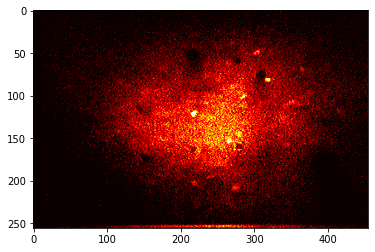

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

srate = 30 #sampling rate is 30 Hz according to dataset info
timevec = np.array(range(len(green)))/srate
npnts = len(timevec)
nFrames = 500 #number of frames to animate
fig, ax = plt.subplots()
ax= plt.imshow(green[6], cmap= 'hot', aspect='auto',animated=True)
plt.clim(0,900)
def animation(i):      
  ax.set_array(green[i])

ani = FuncAnimation(plt.gcf(), animation,frames =nFrames ,interval=1/srate-0.005)
ani.save("animation.gif", dpi=300, writer=PillowWriter(fps=5))

**Image processing to reduce background noise**

Text(0.5, 1.0, 'Biniarized')

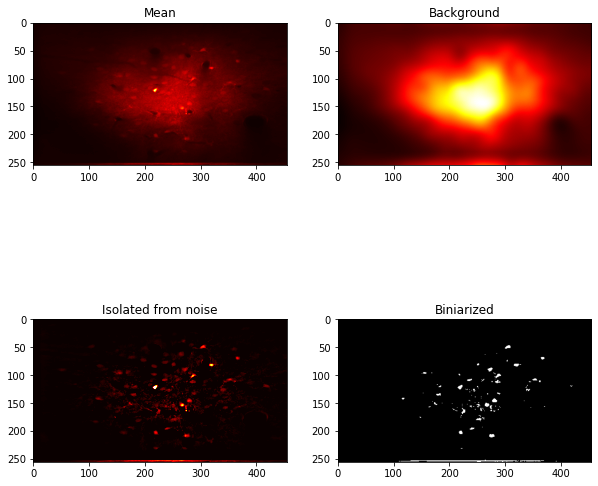

In [ ]:
from IPython.core.pylabtools import figsize
import skimage.filters
import matplotlib.pyplot as plt

avemap = np.mean(np.array(green), axis=0)
avemap = avemap - min(avemap.flatten()) #normalize to a range of [0 1]
avemap = avemap / max(avemap.flatten()) 
background = skimage.filters.gaussian(avemap, sigma=10,mode = 'nearest',truncate=2.0) #estimate the background as a fuzzy version of the image
foreground = avemap - background 
threshval = 0.05  # threshold to identify cell bodies
threshimg = foreground > threshval 

fig,ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(avemap, cmap = 'hot') #the average map
ax[0,0].set_title('Mean')
ax[0,1].imshow(background, cmap='hot') #the background image
ax[0,1].set_title('Background')
ax[1,0].imshow(foreground, cmap='hot').set_clim(0,0.3)
ax[1,0].set_title('Isolated from noise') #the foreground image
ax[1,1].imshow(threshimg,cmap='gray' )
ax[1,1].set_title('Biniarized')

**Activity of neurons over time course**

In [ ]:
from skimage import measure
all_labels, num_labels = measure.label(threshimg, return_num=True)
# clustering of cells into groups of indices

In [ ]:
neuronts = np.zeros((num_labels,npnts)) #get time courses from all "neurons"
green_arr = np.array(green)
for celli in range(num_labels): #extract data from each cell over time
  for timei in range(npnts):
    tmp = green_arr[timei, :,:]
    neuronts[celli, timei] = np.mean(tmp[all_labels==celli+1]) #the average of all pixels in this time point


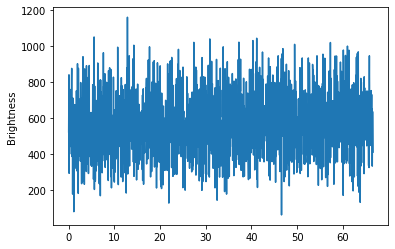

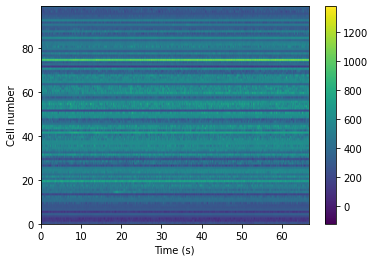

In [ ]:
plt.plot(timevec, neuronts[36,:])
plt.ylabel('Brightness')
plt.show()

plt.imshow(neuronts, aspect='auto', extent = [timevec.min(), timevec.max(),0,num_labels ])
plt.xlabel('Time (s)')
plt.ylabel('Cell number')
plt.colorbar()
plt.show()

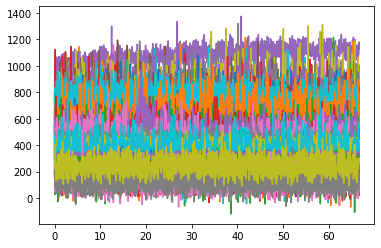

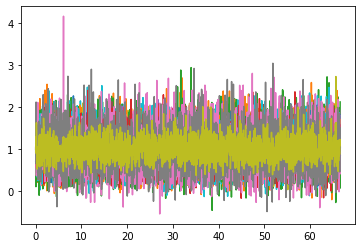

In [ ]:
for i in range(num_labels): 
  plt.plot(timevec, neuronts[i])
plt.show()
deltaf_over_f = neuronts / np.expand_dims(np.mean(neuronts, axis =1 ),axis=1)
for i in range(num_labels):
  plt.plot(timevec, deltaf_over_f[i])
plt.show()
# normalize baseline shifts